<a href="https://colab.research.google.com/github/mattabott/E_commerce_analysis/blob/main/E_commerce_kaggle_pred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##E-Commerce Dataset model predictions
The following dataset is from https://www.kaggle.com/carrie1/ecommerce-data and contain 2010/2011 sales by UK shop. In this notebook we try to create an hybrid model to predict future sales.

The hybrid model is inspired from a Deep learning lesson in Machine Learning Masterclass by DataMasters.it (https://datamasters.it).

At the end of the notebook you will find some little considerations of the model predictions.

The code is written by mattabott (mattabott@gmail.com).

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
import tensorflow as tf

np.random.seed(42)
os.environ['PYTHONHASHSEED'] = '0'
tf.random.set_seed(42)

In [2]:
df = pd.read_csv(
    '/content/drive/MyDrive/Colab Notebooks/Test/Ecommerce_Kaggle/data.csv',
     delimiter=',',
     nrows=None,
     encoding='latin1')

In [3]:
df = df.drop(columns='CustomerID')
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 540455 entries, 0 to 541908
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    540455 non-null  object 
 1   StockCode    540455 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     540455 non-null  int64  
 4   InvoiceDate  540455 non-null  object 
 5   UnitPrice    540455 non-null  float64
 6   Country      540455 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 33.0+ MB


In [4]:
#change quantity from int to float and date from object to Datetime
df['Quantity'] = df.Quantity.astype(float)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 540455 entries, 0 to 541908
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    540455 non-null  object        
 1   StockCode    540455 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     540455 non-null  float64       
 4   InvoiceDate  540455 non-null  datetime64[ns]
 5   UnitPrice    540455 non-null  float64       
 6   Country      540455 non-null  object        
dtypes: datetime64[ns](1), float64(2), object(4)
memory usage: 33.0+ MB


In [5]:
#New column with total price per product
df['tot_price'] = df['Quantity'] * df['UnitPrice']

df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,Country,tot_price
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,2010-12-01 08:26:00,2.55,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6.0,2010-12-01 08:26:00,3.39,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,2010-12-01 08:26:00,2.75,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,2010-12-01 08:26:00,3.39,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,2010-12-01 08:26:00,3.39,United Kingdom,20.34


In [7]:
#Change dataset with only date and tot_price
df_mod = df.copy()
df_mod = df_mod.groupby(pd.Grouper(key='InvoiceDate', freq='H'))['tot_price'].sum().reset_index()
df_mod['InvoiceDate']=pd.to_datetime(df_mod['InvoiceDate'])
df_mod.set_index('InvoiceDate', inplace=True)
df_mod.head()

,tot_price
InvoiceDate,
2010-12-01 08:00:00,1383.81
2010-12-01 09:00:00,7324.24
2010-12-01 10:00:00,5094.33
2010-12-01 11:00:00,4234.16
2010-12-01 12:00:00,7422.42


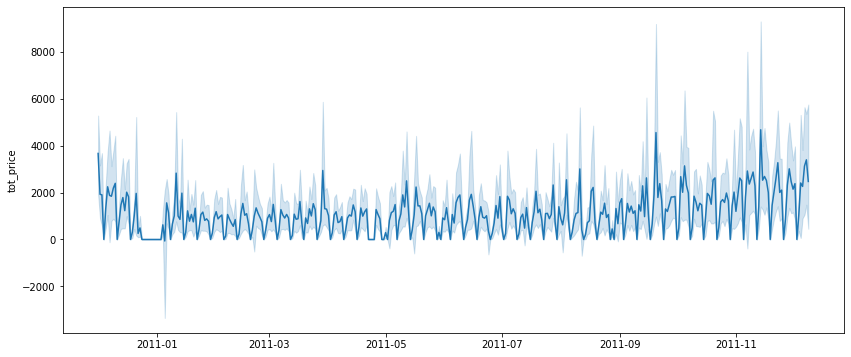

In [8]:
#Plot new dataset
plt.figure(figsize=(14,6))
sns.lineplot(x=df_mod.index.date, y='tot_price', data=df_mod)
plt.show()

In [10]:
#Normalize the dataset to fit on model

scaler = MinMaxScaler(feature_range=(0.2,0.8))
df_norm = scaler.fit_transform(df_mod)

print(df_mod.iloc[0])
print(df_norm[0])

tot_price    1383.81
Name: 2010-12-01 08:00:00, dtype: float64
[0.43542755]


In [11]:
#Divide dataset to have data for price, for time and a y
x_price = []
x_time = []
y = []

step_back = 5

for i in range(len(df_norm) - step_back):
  x_price.append(df_norm[i:i + step_back])
  t = df_mod.iloc[i + step_back -1].name
  x_time.append([t.hour /24,t.weekday()/7])
  y.append(df_norm[i+step_back][0])

In [12]:
#divide data to train and test using 90% for training and 10% for test
split_point = int(len(x_price) * 0.9)

x_train_price = np.asarray(x_price[:split_point], dtype=np.float32)
x_train_time = np.asarray(x_time[:split_point], dtype=np.float32)
y_train = np.asarray(y[:split_point], dtype=np.float32)

x_test_price = np.asarray(x_price[split_point:], dtype=np.float32)
x_test_time = np.asarray(x_time[split_point:], dtype=np.float32)
y_test = np.asarray(y[split_point:], dtype=np.float32)

In [13]:
#Check the shapes
print(x_train_price.shape)
print(x_train_time.shape)
print(y_train.shape)

print('-----------')

print(x_test_price.shape)
print(x_test_time.shape)
print(y_test.shape)

(8056, 5, 1)
(8056, 2)
(8056,)
-----------
(896, 5, 1)
(896, 2)
(896,)


In [24]:
#Create a convolutional block with 1 dimension, with conv_1, pooling layer, conv_2
#and another pooling layer, and close with 2 lstm layers
def get_conv_lstm_block(input, kernel_size_1, kernel_size_2):
  conv_1 = keras.layers.Conv1D(
      filters=24,
      kernel_size=kernel_size_1,
      activation=keras.activations.swish,
      padding='same'
  )(input)

  average_1 = keras.layers.AveragePooling1D()(conv_1)

  conv_2 = keras.layers.Conv1D(
      filters=48,
      kernel_size=kernel_size_2,
      activation=keras.activations.swish,
      padding='same'
  )(average_1)

  average_2 = keras.layers.AveragePooling1D()(conv_2)

  lstm_1 = keras.layers.LSTM(units=16, return_sequences=True)(average_2)
  lstm_2 = keras.layers.LSTM(units=16)(lstm_1)

  return lstm_2

#get inputs
input_price = keras.Input(shape=(x_train_price.shape[1:]), name='Price')
input_time = keras.Input(shape=(x_train_time.shape[1]), name='time')

#starting with 3 convolutional block using up function
conv_1 = get_conv_lstm_block(input_price, kernel_size_1=3, kernel_size_2=2)
conv_2 = get_conv_lstm_block(input_price, kernel_size_1=5, kernel_size_2=3)
conv_3 = get_conv_lstm_block(input_price, kernel_size_1=11, kernel_size_2=7)

#adding 3 Dense layers
dense_time_1 = keras.layers.Dense(units=8, activation='swish')(input_time)
dense_time_2 = keras.layers.Dense(units=16, activation='swish')(dense_time_1)
dense_time_3 = keras.layers.Dense(units=32, activation='swish')(dense_time_2)

#Concatenate 3 convolutional block with last Dense level (for time data)
conc = keras.layers.Concatenate(axis=-1)([conv_1, conv_2, conv_3, dense_time_3])

#adding 3 Dense layers to concatenated one
dense_1 = keras.layers.Dense(units=32, activation=keras.activations.swish)(conc)
dense_2 = keras.layers.Dense(units=32, activation=keras.activations.swish)(dense_1)
dense_3 = keras.layers.Dense(units=16, activation=keras.activations.swish)(dense_2)

#get the output
output = keras.layers.Dense(units=1, activation=keras.activations.linear)(dense_3)

#Let's start to train model
model = keras.Model(inputs=[input_price, input_time], outputs=output)

model.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.mean_absolute_error)

model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Price (InputLayer)             [(None, 5, 1)]       0           []                               
                                                                                                  
 conv1d_24 (Conv1D)             (None, 5, 24)        96          ['Price[0][0]']                  
                                                                                                  
 conv1d_26 (Conv1D)             (None, 5, 24)        144         ['Price[0][0]']                  
                                                                                                  
 conv1d_28 (Conv1D)             (None, 5, 24)        288         ['Price[0][0]']                  
                                                                                            

In [40]:
#Fitting the model
history = model.fit(
    [x_train_price, x_train_time],
    y_train,
    epochs = 100,
    batch_size=48,
    validation_data=(
        [x_test_price, x_test_time],
        y_test
    )
)

Epoch 1/100
168/168 [==============================] - 2s 14ms/step - loss: 0.0051 - val_loss: 0.0096
Epoch 2/100
168/168 [==============================] - 2s 13ms/step - loss: 0.0052 - val_loss: 0.0113
Epoch 3/100
168/168 [==============================] - 2s 13ms/step - loss: 0.0051 - val_loss: 0.0110
Epoch 4/100
168/168 [==============================] - 2s 13ms/step - loss: 0.0052 - val_loss: 0.0103
Epoch 5/100
168/168 [==============================] - 2s 13ms/step - loss: 0.0049 - val_loss: 0.0115
Epoch 6/100
168/168 [==============================] - 2s 13ms/step - loss: 0.0051 - val_loss: 0.0104
Epoch 7/100
168/168 [==============================] - 2s 13ms/step - loss: 0.0050 - val_loss: 0.0103
Epoch 8/100
168/168 [==============================] - 2s 13ms/step - loss: 0.0050 - val_loss: 0.0106
Epoch 9/100
168/168 [==============================] - 2s 13ms/step - loss: 0.0050 - val_loss: 0.0108
Epoch 10/100
168/168 [==============================] - 2s 13ms/step - loss: 0.004

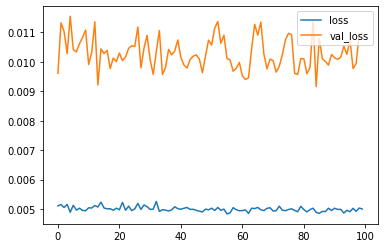

In [41]:
#Plotting the loss and validation loss to see if the model
#is performing well
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(loc='upper right')

plt.show()

In [42]:
#try to predict on test data
preds = model.predict([x_test_price, x_test_time], batch_size=48)


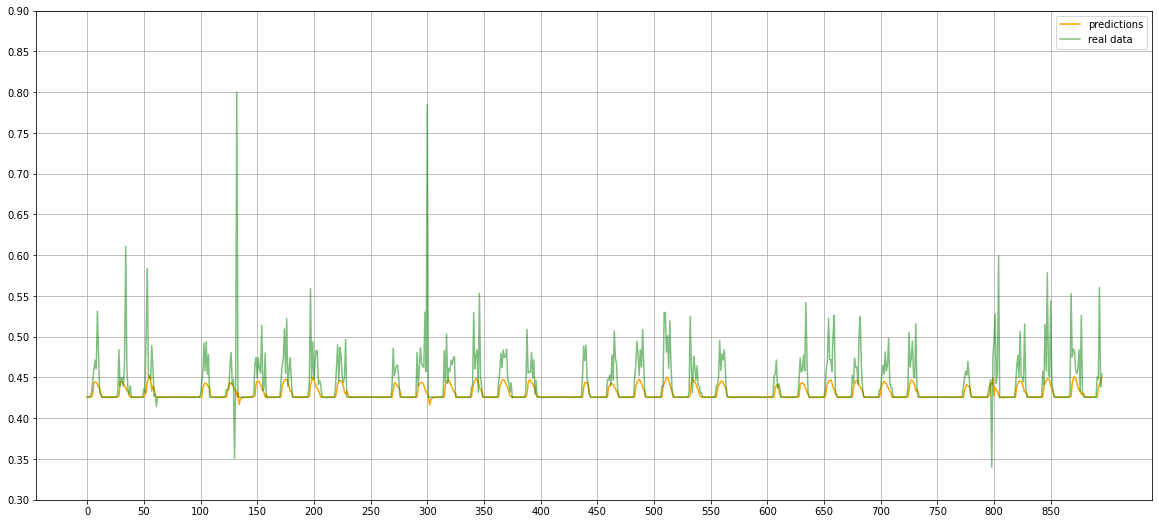

In [43]:
#plot predictions
yticks = []
for i in np.arange(0.3, 0.9, 0.05):
  yticks.append(i)

xticks = []
for i in range(0, 900, 50):
  xticks.append(i)

plt.figure(figsize=(20,9))
plt.plot(preds, color='orange', label='predictions')
plt.plot(y_test, color='green', alpha=0.5, label='real data')
plt.grid()
plt.yticks(ticks=yticks)
plt.xticks(ticks=xticks)
plt.legend()
plt.show()

##Considerations
This kind of model, running on time data and price data, is predicting very well considering poor data quantity.

As we can see up here on the plot, the model prediction and real data are similar, excluding peaks.

With more data this model could predict better and help marketing managers to change products to advertise.